# Analyse statistique descriptive et bibliométrique du corpus

## Import des librairies

Nécessaires à l'import et au traitement des données

In [97]:
import ast
import datetime
from itertools import combinations
from jenkspy import jenks_breaks
from jenkspy import JenksNaturalBreaks
import jenkspy
import matplotlib.pyplot as plt
import nltk
# nltk.download('wordnet') ## à décommenter si complément "wordnet" non installé
from nltk.stem import WordNetLemmatizer
import numpy as np
import os
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
import re
import statistics
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
import time

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Fonctions utilisées pour le pré-traitement et l'analyse statistique

In [40]:
def display_topics(model, features, no_top_words=5):
    for topic,word_vector in enumerate(model.components_):
        total=word_vector.sum()
        largest=word_vector.argsort()[::-1]
        print("\Topic %02d" % topic)
        for i in range(0,no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]],word_vector[largest[i]]*100.0/total))

<>:5: DeprecationWarning: invalid escape sequence \T
<>:5: DeprecationWarning: invalid escape sequence \T
/var/folders/x2/0r_9lwg52699wrns3smq4g2m0000gp/T/ipykernel_1177/68843695.py:5: DeprecationWarning: invalid escape sequence \T
  print("\Topic %02d" % topic)


In [52]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [5]:
def ncs(reflista,reflistb):
    '''NCS stands for normalised coupling strength. Function returns the ncs of two publications. For formulae see: https://doi.org/10.1016/j.joi.2007.07.004'''
    interef=len(list(set(reflista) & set(reflistb)))
    refprod=len(reflista)*len(reflistb)
    divider=pow(refprod,1/2)
    return interef/divider

In [6]:
def lemmatize(expression: str, bigram=False):
    '''Fonction de lemmatisation de monogrammes ou de bigrammes basées sur wordnet'''
    if bigram is False:
        return wnl.lemmatize(expression)
    else:
        splited=expression.split(' ')
        lemms=[wnl.lemmatize(x) for x in splited]
        return ' '.join(lemms)

In [7]:
def replace_inlist(alist:list,pattern:str,replace:str):
    '''simple function to replace an element in a list based on index'''
    if pattern in alist:
        idx=alist.index(pattern)
        alist[idx]= replace
        return alist
    else:
        return alist

In [8]:
def get_distrib(dataframe, col):
    '''Fonction retournant sous la forme d'une courbe la distribution d'une variable en fonction d'un ordre de rangement croissant'''
    tempserie=dataframe[[col]].sort_values(by=col,ascending=True).reset_index()
    tempserie['idx']=tempserie.index
    ax1 = tempserie.plot.line(x='idx',

                      y=col,

                      c='DarkBlue')
    return ax1

In [9]:
def get_neighbours(pattern:str,pivoterm:str,termlist:list):
    '''Fonction retournant pour une liste de termes données les termes précédent jusqu'à deux autres termes un terme de référence et ceux venant  jusqu'à deux termes après le terme de référence'''
    neighbours=[]
    if pattern in termlist:
        idx=termlist.index(pattern)
        if idx >=2:
            neighbours.append(termlist[idx-2])
        else:
            neighbours.append('--')
        if idx >=1:
            neighbours.append(termlist[idx-1])
        else:
            neighbours.append('--')
        neighbours.append(pivoterm)
        if idx+1 < len(termlist):
            neighbours.append(termlist[idx+1])
        else:
            neighbours.append('--')
        if idx+2 < len(termlist):
            neighbours.append(termlist[idx+2])
        else:
            neighbours.append('--')
    if len(neighbours) > 0:
        return neighbours

In [10]:
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenkspy.jenks_breaks(array, classes)
# do the actual classification
    classified = np.array([classify(i, classes) for i in array])
# max value of zones
    maxz = max(classified)
# nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]
# sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)
# sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]
# sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])
# goodness of variance fit
    gvf = (sdam - sdcm) / sdam
    return gvf
def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

In [11]:
def getclass(val,classlist):
    for cl in classlist:
        if classlist.index(cl)< len(classlist)-1:
            if val >= cl[0] and  val < cl[1]:
                return cl
        else:
            return classlist[-1]

Données de références: ids et titres des textes fondateurs des théories du verrouillage technologique

In [12]:
seedsdic={'031-620-848-395-049':'''Why are institutions the ‘carriers of history’?: Path dependence and the evolution of conventions, organizations and institutions''',
          '138-335-719-527-313':'''Clio and the economics of QWERTY''',
          '078-540-302-576-45X':'''Competing Technologies, Increasing Returns, and Lock-In by Historical Events''',
          '157-501-463-801-357':'''Increasing Returns and Path Dependence in the Economy''',
          '003-422-869-824-612':'''The Fable of Keys''',
          '057-519-331-033-253':'''Path Dependence, Lock-In, and History''',
          '078-422-899-116-204':'''Sprayed to Death: Path Dependence, Lock-in and Pest Control Strategies''',
          '120-557-893-863-777':'''Nuclear Power Reactors: A Study in Technological Lock-in'''}

## Import des corpus

corp_x2df => Corpus retenu pour les analyses, critère de pertinence = 2

corp_x3df => Corpus obtenu avec critère de pertinence = 3

corp_x0df => Corpus obtenu en l'absence de critère de pertinence 

### Import des corpus dans un dataframe

In [13]:
corp_x2df=pd.read_excel('Data_Sources_Lens_V2_withBC_20240113_FINAL.xlsx',sheet_name='correctdf')
corp_x0df=pd.read_excel('Data_Sources_Lens_V2_withoutBC_20240113_FINAL.xlsx',sheet_name='correctdf')
corp_x3df=pd.read_excel('Data_Sources_Lens_V2_withBC3_20240113_FINAL.xlsx',sheet_name='correctdf')

### Normalisation

a/ transformation des listes au format texte en objet liste pour faciliter les manipulations

In [14]:
corp_x2df['ref_list']=corp_x2df['ref_list'].apply(lambda x: ast.literal_eval(x))
corp_x3df['ref_list']=corp_x3df['ref_list'].apply(lambda x: ast.literal_eval(x))
corp_x0df['ref_list']=corp_x0df['ref_list'].apply(lambda x: ast.literal_eval(x))
corp_x2df['auth_list']=corp_x2df['auth_list'].apply(lambda x: ast.literal_eval(x))
corp_x3df['auth_list']=corp_x3df['auth_list'].apply(lambda x: ast.literal_eval(x))
corp_x0df['auth_list']=corp_x0df['auth_list'].apply(lambda x: ast.literal_eval(x))
corp_x2df.txt_tokens=corp_x2df.txt_tokens.apply(lambda x: ast.literal_eval(x))
corp_x2df.txt_bigrams=corp_x2df.txt_bigrams.apply(lambda x: ast.literal_eval(x))

b/ Calcul de scores de citations: lcs = score de citation locals, spcs = score de spécificité, i.e rapport lcs/nb. total de citation de la publication

In [15]:
corp_x2df['lcs']=corp_x2df.lens_id.apply(lambda x:len(corp_x2df[corp_x2df.lens_id!=x].loc[corp_x2df[corp_x2df.lens_id!=x].ref_list.apply(lambda z: x in z)]))
corp_x3df['lcs']=corp_x3df.lens_id.apply(lambda x:len(corp_x3df[corp_x3df.lens_id!=x].loc[corp_x3df[corp_x3df.lens_id!=x].ref_list.apply(lambda z: x in z)]))
corp_x0df['lcs']=corp_x0df.lens_id.apply(lambda x:len(corp_x0df[corp_x0df.lens_id!=x].loc[corp_x0df[corp_x0df.lens_id!=x].ref_list.apply(lambda z: x in z)]))
corp_x2df['spcs']=corp_x2df.apply(lambda row: row['lcs']/row['scholarly_citations_count'],axis=1)
corp_x3df['spcs']=corp_x3df.apply(lambda row: row['lcs']/row['scholarly_citations_count'],axis=1)
corp_x0df['spcs']=corp_x0df.apply(lambda row: row['lcs']/row['scholarly_citations_count'],axis=1)
corp_x2df['txt_size']=corp_x2df.txt_tokens.apply(lambda x: len(x))

c/ vérification du recouvrement entre corpus

In [16]:
corp_x2_corp_x3=len([x for x in corp_x2df.lens_id.to_list() if x in corp_x3df.lens_id.to_list()])
print(f'Nombre de publications communes entre BC2 et BC3: {corp_x2_corp_x3}')

corp_x2_x_corp_x3=len([x for x in corp_x2df.lens_id.to_list() if x not in corp_x3df.lens_id.to_list()])
print(f'Nombre de publications dans BC2 absentes de BC3: {corp_x2_corp_x3}')

corp_x3_x_corp_x2=len([x for x in corp_x3df.lens_id.to_list() if x not in corp_x2df.lens_id.to_list()])
print(f'Nombre de publications dans BC3 absentes de BC2: {corp_x3_x_corp_x2}')

corp_x2_corp_x0=len([x for x in corp_x2df.lens_id.to_list() if x in corp_x0df.lens_id.to_list()])
print(f'Nombre de publications communes BC2 - BC0: {corp_x2_corp_x3}')

corp_x2_x_corp_x0=len([x for x in corp_x2df.lens_id.to_list() if x not in corp_x0df.lens_id.to_list()])
print(f'Nombre de publications dans BC2 absentes de BC0: {corp_x2_x_corp_x0}')

corp_x3_corp_x0=len([x for x in corp_x3df.lens_id.to_list() if x in corp_x0df.lens_id.to_list()])
print(f'Nombre de publications communes BC3 - BC0: {corp_x2_corp_x3}')

corp_x3_x_corp_x0=len([x for x in corp_x3df.lens_id.to_list() if x not in corp_x0df.lens_id.to_list()])
print(f'Nombre de publications dans BC3 absentes de BC0: {corp_x3_x_corp_x0}')

Nombre de publications communes entre BC2 et BC3: 60
Nombre de publications dans BC2 absentes de BC3: 60
Nombre de publications dans BC3 absentes de BC2: 0
Nombre de publications communes BC2 - BC0: 60
Nombre de publications dans BC2 absentes de BC0: 0
Nombre de publications communes BC3 - BC0: 60
Nombre de publications dans BC3 absentes de BC0: 0


## Analyse du corpus retenu 


Pour rappel name= corp_x2df, n=75

### Preprocessing et description des données

Simple rappel des colonnes présentes dans le dataframe

In [17]:
corp_cols=list(corp_x2df.columns)
print(corp_cols)

['lens_id', 'title', 'publication_type', 'abstract', 'text_dat', 'source_title', 'year', 'month', 'day', 'doi', 'authors', 'auth_list', 'fields', 'references', 'ref_list', 'scholarly_citations_count', 'nb_ref', 'nb_cited_tf', 'tf_weight', 'cited_concepts', 'cited_agri', 'indomain', 'BC', 'lcs_ci', 'spscore_ci', 'txt_dat', 'txt_tokens', 'txt_bigrams', 'unigram_agri', 'bigram_agri', 'unigram_concept', 'bigram_concept', 'unigram_concept_failed', 'bigram_concept_failed', 'lcs', 'spcs', 'txt_size']


#### Description des types d'objets contenus dans les colonnes du dataframe

In [18]:
print(corp_x2df.dtypes)

lens_id                       object
title                         object
publication_type              object
abstract                      object
text_dat                      object
source_title                  object
year                           int64
month                          int64
day                          float64
doi                           object
authors                       object
auth_list                     object
fields                        object
references                    object
ref_list                      object
scholarly_citations_count      int64
nb_ref                         int64
nb_cited_tf                    int64
tf_weight                    float64
cited_concepts                object
cited_agri                    object
indomain                       int64
BC                           float64
lcs_ci                       float64
spscore_ci                   float64
txt_dat                       object
txt_tokens                    object
t

#### Normalisation/Desambiguisation des noms d'auteurs

Un seul mispell a été trouvé ici sur l'écriture du prénom de l'auteur 'Valérie Micard

In [19]:
# Listes de l'ensemble des auteurs référencés dans le corpus

all_authors=list(np.unique([y for x in corp_x2df.auth_list.to_list() for y in x]))
print(len(all_authors))

277


In [20]:
# doublon détecté: "Valérie Micard": mauvaise orthographe du prénom
corp_x2df.auth_list=corp_x2df.auth_list.apply(lambda x: replace_inlist(x,"Valerie Micard","Valérie Micard"))

#### Classification des scores de citation calculés: lcs et spcs

La classification est réalisée avec l'algorithme de Fisher-Jenks comme il s'agit de déterminer des classes pour une varibale univarié.
Voir :
- https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization
- https://medium.com/analytics-vidhya/jenks-natural-breaks-best-range-finder-algorithm-8d1907192051
- https://pbpython.com/natural-breaks.html


In [21]:
gvf = 0.0
nclasses_lcs = 2
while gvf < .8:
    gvf = goodness_of_variance_fit(corp_x2df.lcs, nclasses_lcs)
    nclasses_lcs += 1
print(nclasses_lcs)

4


In [22]:
breaks_lcs = jenks_breaks(corp_x2df.lcs, n_classes=nclasses_lcs)
print(breaks_lcs)

[0, 3, 11, 23, 38]


In [23]:
corp_x2df['lcs_cut_jenks'] = pd.cut(corp_x2df['lcs'],
                        bins=breaks_lcs,
                        labels=['[0-3[', '[3-11[','[11-23[','[23-38['])
corp_x2df['lcs_cut_jenks'].fillna('[0-3[', inplace=True)

In [24]:
corp_x2df.groupby('lcs_cut_jenks').size().to_frame('Nb_Publications').sort_values(by='Nb_Publications',ascending=False).reset_index()

lcs_cut_jenks  Nb_Publications
0         [0-3[               59
1        [3-11[               12
2       [11-23[                3
3       [23-38[                1

In [25]:
gvf = 0.0
nclasses_spcs = 2
while gvf < .8:
    gvf = goodness_of_variance_fit(corp_x2df.spcs, nclasses_spcs)
    nclasses_spcs += 1
print(nclasses_spcs)

4


In [26]:
breaks_spcs = jenks_breaks(corp_x2df.spcs, n_classes=nclasses_spcs)
print(breaks_spcs)

[0.0, 0.03125, 0.095, 0.2, 0.3076923076923077]


In [27]:
corp_x2df['spcs_cut_jenks'] = pd.cut(corp_x2df['spcs'],
                        bins=breaks_spcs,
                        labels=['[0-0.031[', '[0.031-0.095[','[0.095-0.2[','[0.2- 0.307['])
corp_x2df['spcs_cut_jenks'].fillna('[0-0.031[', inplace=True)

In [28]:
corp_x2df.groupby('spcs_cut_jenks').size().to_frame('Nb_Publications').sort_values(by='Nb_Publications',ascending=False).reset_index()

spcs_cut_jenks  Nb_Publications
0      [0-0.031[               40
1  [0.031-0.095[               17
2    [0.095-0.2[               13
3   [0.2- 0.307[                5

#### Description statistique simple de certaines colonnes d'intérêt

In [29]:
# Citations BDDB
print(f'La moyenne du score de citation global est de : {corp_x2df.scholarly_citations_count.mean()}')
print(f'La médiane du score de citation global est de : {corp_x2df.scholarly_citations_count.median()}')
print(f'Le max du score de citation global est de : {corp_x2df.scholarly_citations_count.max()}')
print(f'Le min du score de citation global est de : {corp_x2df.scholarly_citations_count.min()}')
print(f'L\'écart type du score de citation global est de : {corp_x2df.scholarly_citations_count.std()}')
print(f'La variance du score de citation global est de : {corp_x2df.scholarly_citations_count.var()}')

La moyenne du score de citation global est de : 36.81333333333333
La médiane du score de citation global est de : 12.0
Le max du score de citation global est de : 436
Le min du score de citation global est de : 1
L'écart type du score de citation global est de : 74.03609297540667
La variance du score de citation global est de : 5481.343063063062


<AxesSubplot:>

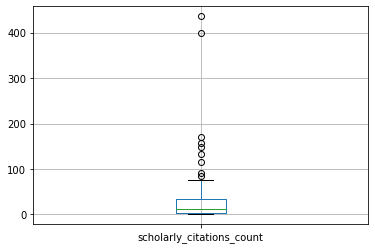

In [30]:
corp_x2df.boxplot('scholarly_citations_count')

In [31]:
# Local Citation score
print(f'La moyenne du score de citation local est de : {corp_x2df.lcs.mean()}')
print(f'La médiane du score de citation local est de : {corp_x2df.lcs.median()}')
print(f'Le max du score de citation local est de : {corp_x2df.lcs.max()}')
print(f'Le min du score de citation local est de : {corp_x2df.lcs.min()}')
print(f'L\'écart type du score de citation local est de : {corp_x2df.lcs.std()}')
print(f'La variance du score de citation local est de : {corp_x2df.lcs.var()}')


La moyenne du score de citation local est de : 2.72
La médiane du score de citation local est de : 1.0
Le max du score de citation local est de : 38
Le min du score de citation local est de : 0
L'écart type du score de citation local est de : 6.008012667780937
La variance du score de citation local est de : 36.09621621621621


<AxesSubplot:>

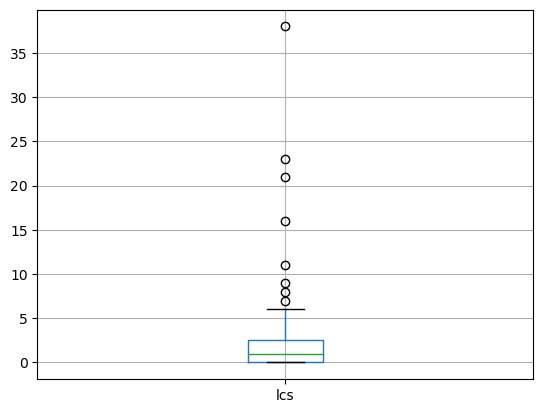

In [32]:
corp_x2df.boxplot('lcs')

In [33]:
# Specificity Score
print(f'La moyenne du score de spécificité est de : {corp_x2df.spcs.mean()}')
print(f'La médiane du score de spécificité est de : {corp_x2df.spcs.median()}')
print(f'Le max du score de spécificité est de : {corp_x2df.spcs.max()}')
print(f'Le min du score de spécificité est de : {corp_x2df.spcs.min()}')
print(f'L\'écart type score de spécificité est de : {corp_x2df.spcs.std()}')
print(f'La variance du score de spécificité est de : {corp_x2df.spcs.var()}')

La moyenne du score de spécificité est de : 0.06076057136625431
La médiane du score de spécificité est de : 0.023255813953488372
Le max du score de spécificité est de : 0.3076923076923077
Le min du score de spécificité est de : 0.0
L'écart type score de spécificité est de : 0.08317578395108566
La variance du score de spécificité est de : 0.006918211035877679


<AxesSubplot:>

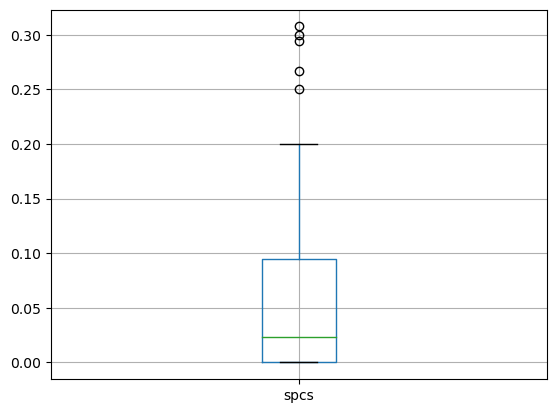

In [34]:
corp_x2df.boxplot('spcs')

Étendue temporelle du corpus

In [35]:
timerepdf=corp_x2df.groupby('year').size().to_frame('Nb_Publications').sort_values(by='year',ascending=True).reset_index()
timerepdf=timerepdf.rename(columns={'year':'Date_Publication'})
timerepdf['Croissance(%)']=timerepdf['Nb_Publications'].pct_change()
timerepdf['Croissance(%)']=timerepdf['Croissance(%)'].apply(lambda x: round(x,2)*100)
#timerepdf['Effectifs cumulés']=timerepdf.Nb_Publications.cumsum()
print(timerepdf.to_latex(index=False, float_format="{:.1f}".format))

\begin{tabular}{rrr}
\toprule
 Date\_Publication &  Nb\_Publications &  Croissance(\%) \\
\midrule
             1996 &                2 &            NaN \\
             2000 &                1 &          -50.0 \\
             2007 &                1 &            0.0 \\
             2008 &                2 &          100.0 \\
             2009 &                1 &          -50.0 \\
             2010 &                2 &          100.0 \\
             2012 &                4 &          100.0 \\
             2014 &                3 &          -25.0 \\
             2015 &                2 &          -33.0 \\
             2016 &                5 &          150.0 \\
             2017 &                4 &          -20.0 \\
             2018 &                7 &           75.0 \\
             2019 &                8 &           14.0 \\
             2020 &               10 &           25.0 \\
             2021 &                5 &          -50.0 \\
             2022 &               10 &        

/var/folders/x2/0r_9lwg52699wrns3smq4g2m0000gp/T/ipykernel_1177/175665911.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(timerepdf.to_latex(index=False, float_format="{:.1f}".format))


In [153]:
timerepdf

Date_Publication  Nb_Publications  Croissance(%)
0               1996                2            NaN
1               2000                1          -50.0
2               2007                1            0.0
3               2008                2          100.0
4               2009                1          -50.0
5               2010                2          100.0
6               2012                4          100.0
7               2014                3          -25.0
8               2015                2          -33.0
9               2016                5          150.0
10              2017                4          -20.0
11              2018                7           75.0
12              2019                8           14.0
13              2020               10           25.0
14              2021                5          -50.0
15              2022               10          100.0
16              2023                8          -20.0

### Analyse thématique du corpus

Similarité cosine entre éléments du corpus

In [36]:
def dummy(doc):
    return doc

In [146]:
%%time
#cvec = CountVectorizer(tokenizer=dummy,lowercase=False,preprocessor=dummy)
#sparse_matrix = cvec.fit_transform(corp_x2df.txt_tokens.to_list())
#tfidf=TfidfTransformer()
tfidf_txt=TfidfVectorizer(tokenizer=dummy, lowercase=False, preprocessor=dummy,min_df=3)
vectors_txt=tfidf_txt.fit_transform(corp_x2df.txt_tokens.to_list())
vectors_txt.shape
#tfidf_sparse=tfidf.fit_transform(sparse_matrix)
tfidfmatrix=pd.DataFrame(vectors_txt.toarray(),columns=tfidf_txt.get_feature_names_out())
tfidfmatrix = tfidfmatrix.set_axis(corp_x2df['lens_id'])

CPU times: user 15.2 ms, sys: 7.69 ms, total: 22.9 ms
Wall time: 26.1 ms


/Users/tristansalord/opt/anaconda3/envs/TextMining/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Construction du dataframe

In [63]:
cs_corp_x2df=pd.DataFrame(cosine_similarity(tfidfmatrix,tfidfmatrix))
cs_corp_x2df=cs_corp_x2df.set_axis(corp_x2df['lens_id'])
for col,lid in zip(cs_corp_x2df.columns,corp_x2df['lens_id'].to_list()):
    cs_corp_x2df=cs_corp_x2df.rename(columns={col:lid})

In [64]:
retrieved_row=[]
retrieved_val=[]
for idx in cs_corp_x2df.index.to_list():
     for lid in list(cs_corp_x2df.columns):
        if idx != lid:
            if (idx,lid) not in retrieved_row:
                if (lid,idx) not in retrieved_row:
                    #print('found')
                    retrieved_row.append((idx,lid))
                    retrieved_val.append(cs_corp_x2df[lid][cs_corp_x2df.index == idx].iloc[0])  

cs_edge_tbl=pd.DataFrame(data=retrieved_row,columns=['Source','Target'])
cs_edge_tbl['Cosine Sim.']=retrieved_val



In [66]:
cs_edge_tbl[cs_edge_tbl['Cosine Sim.'] >=0.25]

Source               Target  Cosine Sim.
15    002-302-746-732-248  017-179-409-314-33X     0.266440
30    002-302-746-732-248  030-360-558-296-654     0.424797
44    002-302-746-732-248  013-160-801-537-807     0.278283
49    002-302-746-732-248  159-181-519-494-783     0.411226
160   023-197-236-631-391  017-179-409-314-33X     0.279109
...                   ...                  ...          ...
2592  085-434-095-225-749  023-976-368-456-727     0.408211
2597  085-434-095-225-749  125-667-682-566-851     0.354532
2664  070-364-061-118-35X  141-534-782-266-46X     0.269495
2683  100-229-598-686-140  027-498-111-430-312     0.263922
2702  008-109-612-636-705  125-667-682-566-851     0.282757

[72 rows x 3 columns]

Topic Modeling (NMF & SVD)

In [147]:
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

In [69]:
# svd_txt_mdl=TruncatedSVD(n_components=10, random_state=200)
# W_txt_mtx=svd_txt_mdl.fit_transform(tfidf_sparse)
# H_txt_mtx=svd_txt_mdl.components_

In [145]:
### initial source: https://predictivehacks.com/topic-modelling-with-nmf-in-python/

# components_df = pd.DataFrame(nmf_txt_mdl.components_, columns=tfidf_txt.get_feature_names_out())
# components_df

In [73]:
corp_x2df.title[corp_x2df.index==10].iloc[0]

'Path dependencies in Norwegian dairy and beef farming communities: Implications for climate mitigation'

In [148]:
# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=9, random_state=200)
 
# Fit the model to TF-IDF
model.fit(vectors_txt)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(vectors_txt)

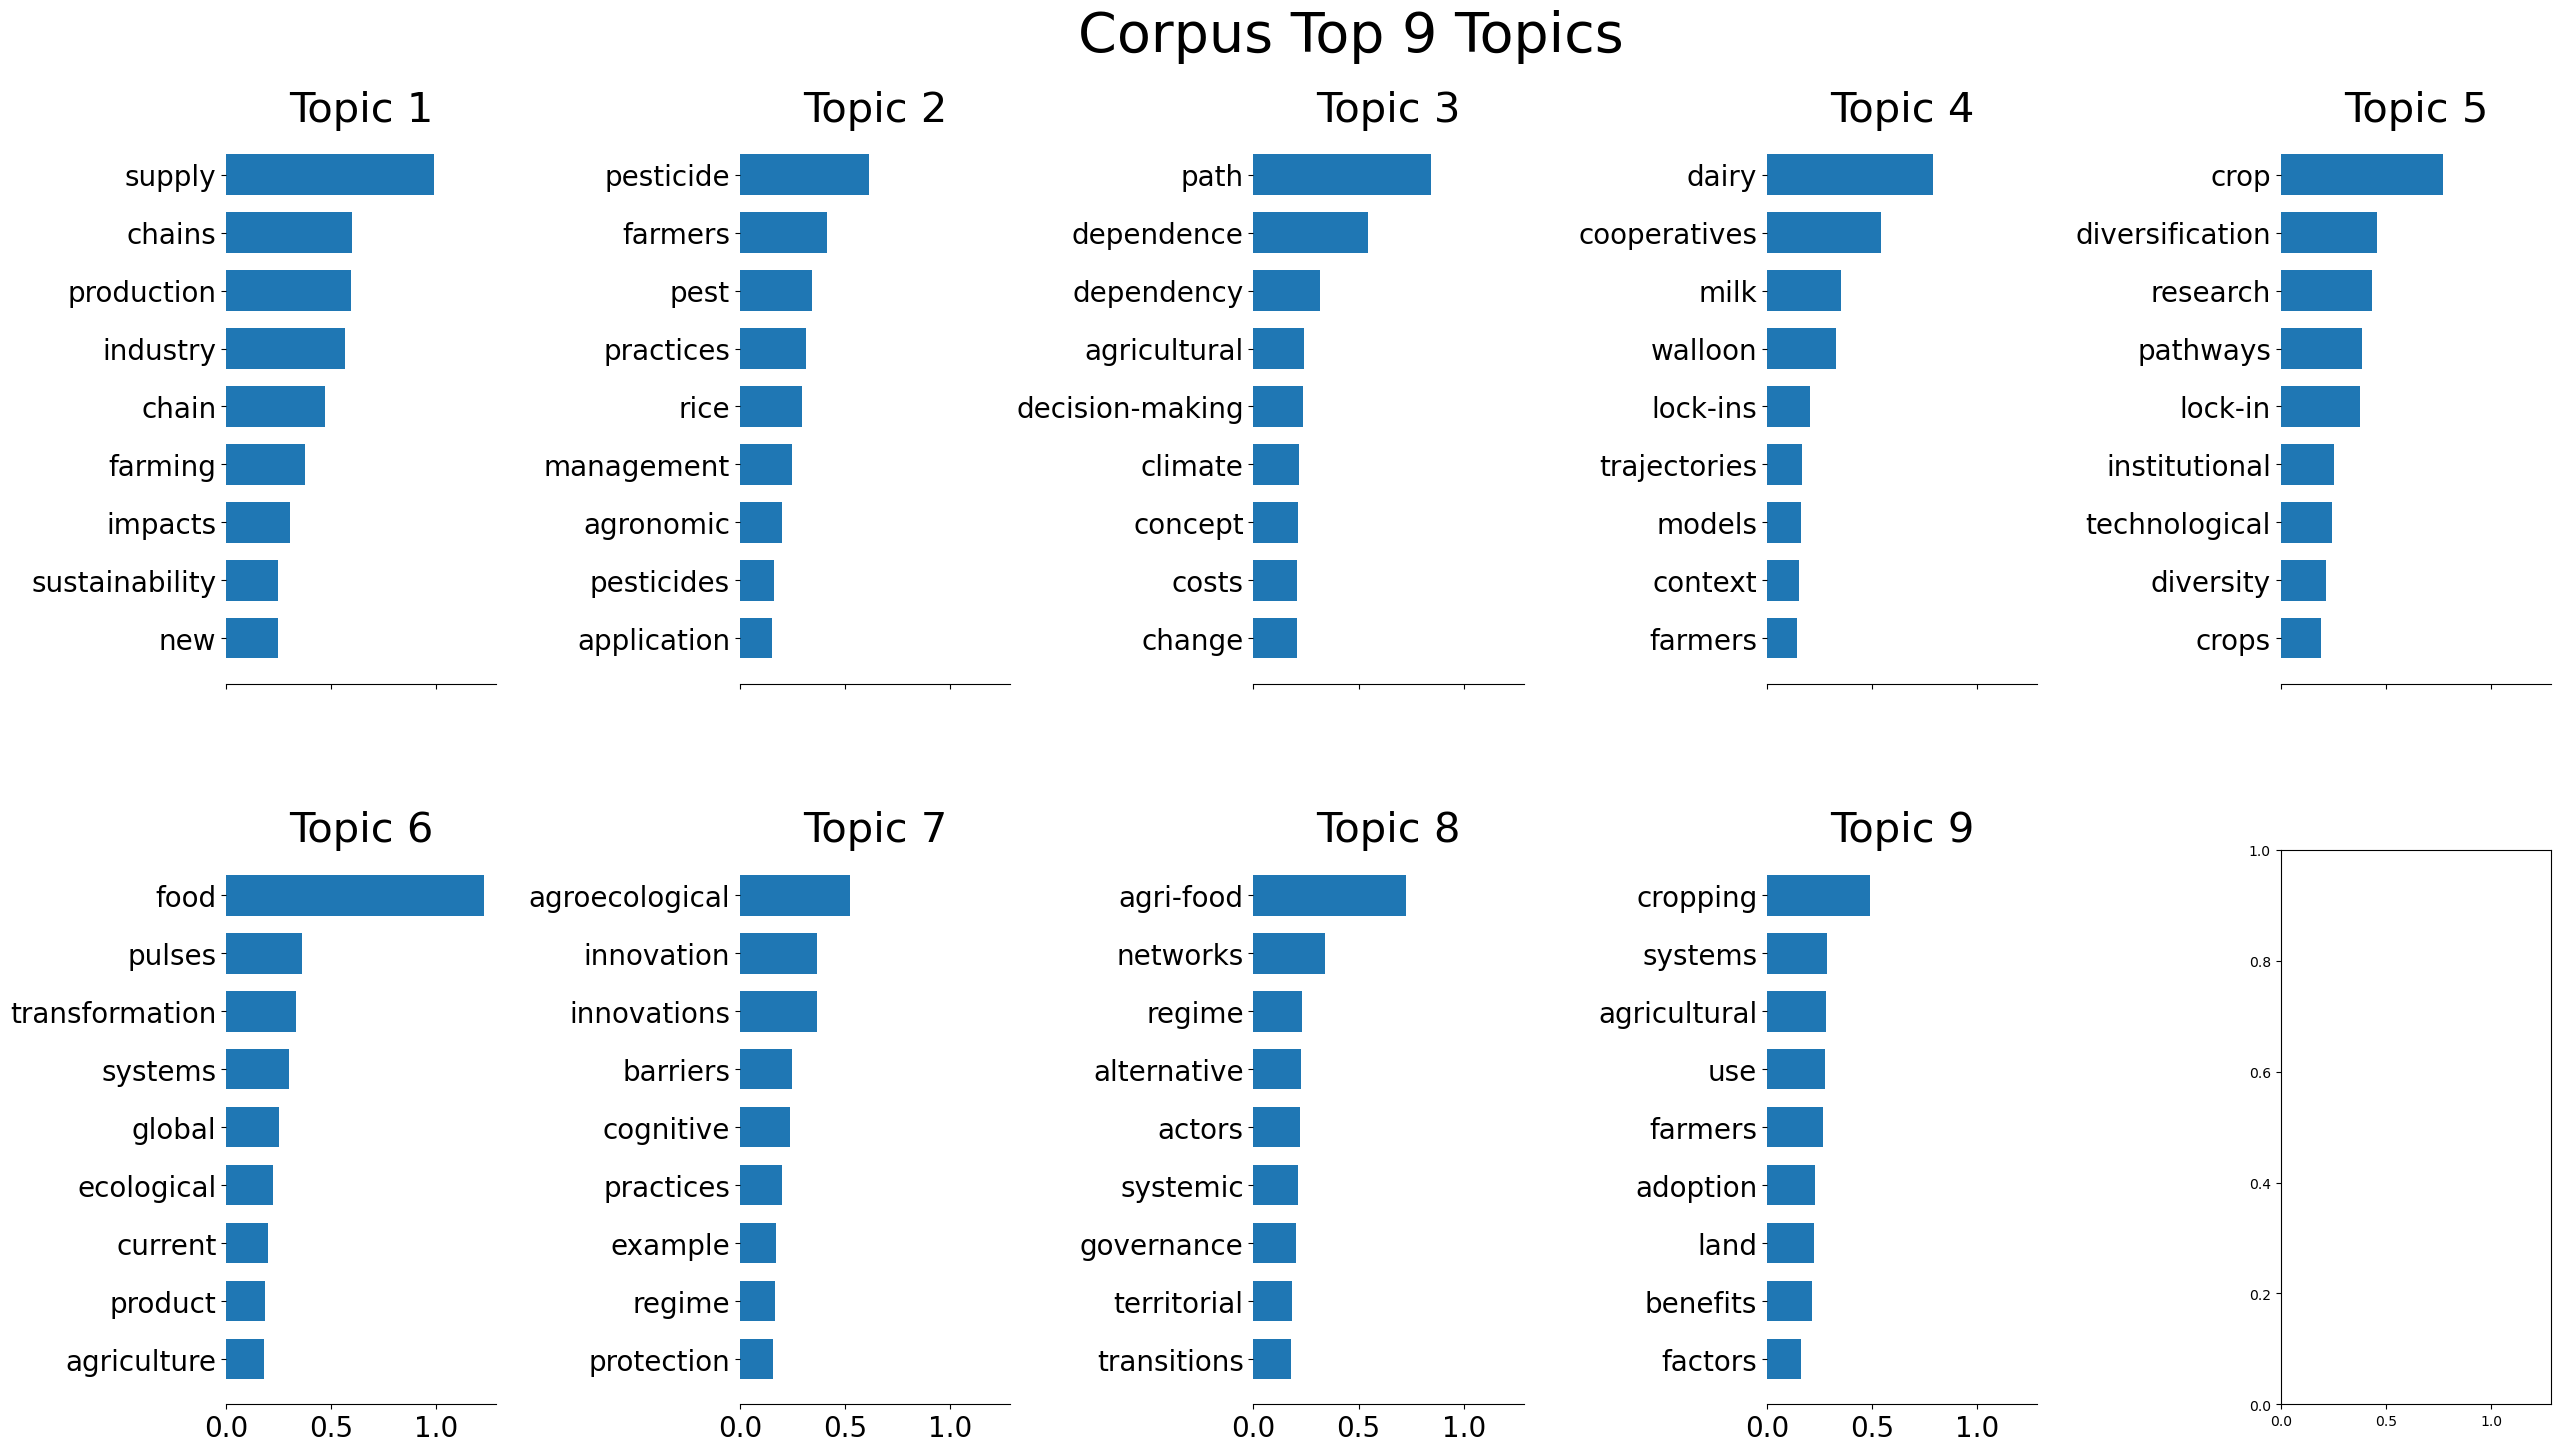

In [149]:
plot_top_words(model,tfidf_txt.get_feature_names_out(),9,'Corpus Top 9 Topics' )

In [150]:
## Nombre de documents par topics
topic_size=pd.DataFrame(nmf_features).idxmax(axis=1).value_counts().to_frame()
topic_size['Topic']=topic_size.index.to_list()
topic_size['Topic']=topic_size.Topic.apply(lambda x: 'Topic '+str(x))
topic_size=topic_size.rename(columns={0:'Nb. de Publications'})
topic_size=topic_size[['Topic','Nb. de Publications']]
print(topic_size.to_latex())

\begin{tabular}{llr}
\toprule
{} &    Topic &  Nb. de Publications \\
\midrule
2 &  Topic 2 &                   14 \\
8 &  Topic 8 &                   12 \\
4 &  Topic 4 &                    9 \\
5 &  Topic 5 &                    8 \\
7 &  Topic 7 &                    7 \\
0 &  Topic 0 &                    7 \\
3 &  Topic 3 &                    6 \\
1 &  Topic 1 &                    6 \\
6 &  Topic 6 &                    6 \\
\bottomrule
\end{tabular}



/var/folders/x2/0r_9lwg52699wrns3smq4g2m0000gp/T/ipykernel_1177/344975808.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(topic_size.to_latex())


In [124]:
idx_list=corp_x2df.index.to_list()
topics=[pd.DataFrame(nmf_features).loc[x].idxmax() for x in idx_list]
corp_x2df['NMF_Topics'] = topics

In [139]:
corp_x2df[['NMF_Topics','title','auth_list']].sort_values(by='NMF_Topics',ascending=True).to_excel('NMF_Topics_Docs.xlsx',index=False)

In [92]:
corp_x2df.title[corp_x2df.index ==4].iloc[0]

'The drivers of product innovations in pulse-based foods: insights from case studies in France, Italy and USA'

In [151]:
#### Topic Visulaisation

vis = pyLDAvis.lda_model.prepare(model, vectors_txt, tfidf_txt)

/Users/tristansalord/opt/anaconda3/envs/TextMining/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/tristansalord/opt/anaconda3/envs/TextMining/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/tristansalord/opt/anaconda3/envs/TextMining/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [152]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.065690 -0.054972       1        1  15.361980
2      0.076536 -0.062386       2        1  13.129108
1     -0.122624 -0.295890       3        1  11.889803
5     -0.014045  0.113296       4        1  11.407147
6     -0.089776  0.132397       5        1  10.531346
4     -0.210380  0.138174       6        1  10.136735
7      0.205452  0.033802       7        1   9.999891
3      0.188248  0.004006       8        1   8.956869
0      0.032280 -0.008426       9        1   8.587119, topic_info=              Term      Freq     Total Category  logprob  loglift
222           food  3.000000  3.000000  Default  30.0000  30.0000
390           path  4.000000  4.000000  Default  29.0000  29.0000
123           crop  4.000000  4.000000  Default  28.0000  28.0000
398      pesticide  3.000000  3.000000  Default  27.0000  27.0000
129          dairy  2.000000  2.000000  Default  26.0000  26.0000
..             ...       ...       ...      ...      ...      ...
182  environmental  0.264766  1.314774   Topic9  -4.8980   0.8523
125          crops  0.256705  1.666768   Topic9  -4.9290   0.5842
266       improved  0.212911  0.608733   Topic9  -5.1160   1.4044
404         policy  0.221031  1.413988   Topic9  -5.0786   0.5990
282    innovations  0.213222  2.483787   Topic9  -5.1145  -0.0003

[441 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3         7  0.642238        actors
10        1  1.316180         adopt
11        1  0.596344      adoption
15        7  0.807148     agri-food
16        1  0.306052  agricultural
...     ...       ...           ...
560       1  0.950679            us
561       1  0.421559           use
561       3  0.421559           use
567       3  1.939189      villages
569       8  0.965348       walloon

[120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 2, 6, 7, 5, 8, 4, 1])